# Deep Cox Mixtures with Heterogenous Effects (CMHE) Demo
<hr>

Author: ***Mononito Goswami***  &lt;mgoswami@cs.cmu.edu&gt;

<div style=" float: right;">
<img align="right" src="https://ndownloader.figshare.com/files/34052981" width="25%"/>
<img align="right" src="https://www.cs.cmu.edu/~chiragn/auton_logo.png" width="25%"/>
</div>

# Contents



### 1. [Introduction](#introduction) 


### 2. [Synthetic Data](#syndata) 
####    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  2.1 [Generative Process for the Synthetic Dataset.](#gensyndata)
####    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  2.2 [Loading and Visualizing the Dataset.](#vissyndata)
####    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  2.3 [Split Dataset into Train and Test.](#splitdata)

       
### 3. [Counterfactual Phenotyping](#phenotyping)

####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   3.1 [Phenotyping with CMHE](#phenocmhe)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   3.2 [Comparison with Clustering](#clustering)


### 4. [Factual Regression](#regression)
#### &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   4.1 [Factual Regression with CMHE](#regcmhe)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   4.2 [Comparison with a Deep Cox Proportional Hazards Model](#deepcph)

<hr>


<a id='introduction'></a>

## 1. Introduction
<img src="https://ndownloader.figshare.com/files/34056269">
<b>Figure A: Schematic Description of CMHE:</b>The set of features (confounders) $\mathbf{x}$ are passed through an encoder to obtain deep non-linear representations. These representations then describe the latent phenogroups $\mathbf{P}(Z|X=\mathbf{x})$ and $\mathbf{P}(\mathbf{\phi}|X=\mathbf{x})$ that determine the base survival rate and the treatment effect respectively. Finally, the individual level hazard (survival) curve under an intervention $A=\mathbf{a}$ is described by marginalizing over $Z$ and $\mathbf{\phi}$ as $\mathbf{S}(t|X=x, A=a) = \mathbf{E}_{(Z,\mathbf{\phi)}\sim \mathbf{P}(\cdot|X)}\big[ \mathbf{S}(t|A=\mathbf{a}, X, Z, \mathbf{\phi})\big]$. 




<img width=30% src="https://figshare.com/ndownloader/files/34056284" align=right>


<p> <b>Cox Mixture with Heterogenous Effects (CMHE)</b> is a flexible approach to recover counterfactual phenotypes of individuals that demonstrate heterogneous effects to an intervention in terms of censored Time-to-Event outcomes. CMHE is not restricted by the strong Cox Proportional Hazards assumption or any parametric assumption on the time to event distributions. CMHE achieves this by describing each individual as belonging to two different latent groups, 
$Z$ that mediate the base survival rate and $\phi$ the effect of the treatment. CMHE can also be employed to model individual level counterfactuals or for standard factual survival regression.

**Figure B (Right)**: CMHE in Plate Notation. $\mathbf{x}$ confounds treatment assignment $A$ and outcome $T$ (Model parameters and censoring distribution have been abstracted out).

    
    
*For full details on Cox Mixtures with Heterogenous Effects, please refer to our preprint*:

[Counterfactual Phenotyping with Censored Time-to-Events, arXiv preprint, C. Nagpal, M. Goswami, K. Dufendach, A. Dubrawski](https://arxiv.org/abs/2202.11089)



<a id="syndata"></a>

## 2. Synthetic Data Example


In [ ]:
# Suppress all warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import torch
from tqdm import tqdm 
import sys
sys.path.append('../')

from auton_survival.datasets import load_dataset
from cmhe_demo_utils import * 

<a id="gensyndata"></a>
### 2.1. Generative Process for the Synthetic Data

1. Features $x_1$, $x_2$ and the base survival phenotypes $Z$ are sampled from $\texttt{scikit-learn's make_blobs(...)}$ function which generates isotropic Gaussian blobs:
$$[x_1, x_2], Z \sim \texttt{sklearn.datasets.make_blobs(K = 3)}$$
2. Features $x_3$ and $x_4$ are sampled uniformly, whereas the underlying treatment effect phenotypes $\phi$ are defined according to an $L_1$-ball:
$$ [x_1, x_2] \sim \texttt{Uniform}(-2, 2) $$
$$ \phi \triangleq \mathbb{1}\{|x_3| + |x_3| > 2\} $$
3. We then sample treat assignments from a Bernoulli distribution:
$$ A \sim  \texttt{Bernoulli}(\frac{1}{2}) $$
4. Next, the time-to-event $T$ conditioned on the confounders $x$, latent $Z$ and latent effect group $\phi$ are generated from a Gompertz distribution:
$$ T^{*}| (Z=k, {\phi}=m, A={a}) \sim \nonumber \texttt{Gompertz}\big({\beta}_{k}^{\top}{x} +({-a}^m)\big) $$
5. Finally, the observed time $T$ is obtained after censoring some of the events and censoring time is chosen uniformly at random upto $T^*$:
$$\delta \sim \texttt{Bernoulli}(\frac{3}{4}), \quad C \sim \texttt{Uniform}(0, {T}^{*})$$
$$ T =  \begin{cases} T^*, & \text{if } \delta = 1 \\ C, & \text{if } \delta = 0 \end{cases} $$

In [2]:
# Load the synthetic dataset
outcomes, features, interventions = load_dataset(dataset='SYNTHETIC')

# Let's take a look at take the dataset
features.head(5)

,X1,X2,X3,X4,X5,X6,X7,X8
0,0.148745,1.892484,0.195254,0.860757,0.696523,0.483697,0.339551,0.374794
1,1.139439,-0.943330,0.411054,0.179533,0.428686,0.683057,0.600948,0.070483
2,-0.961237,0.782706,-0.305381,0.583576,0.157478,0.070556,0.034590,0.776005
3,0.466508,0.694348,-0.249651,1.567092,0.850959,0.416178,0.968841,0.863598
4,-0.249002,-0.552091,1.854651,-0.466234,0.860385,0.367184,0.954347,0.748930


<a id="vissyndata"></a>
### 2.2. Visualizing the Synthetic Data

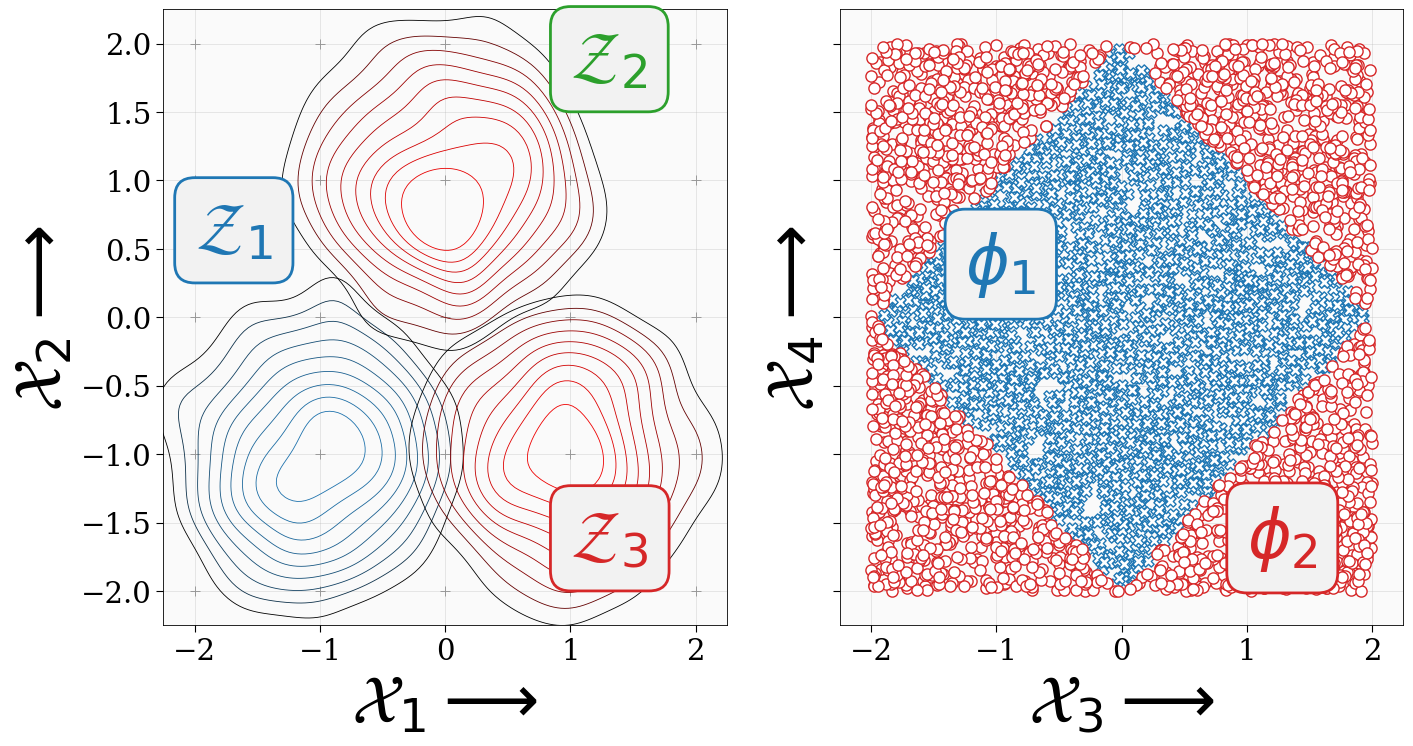

In [3]:
plot_synthetic_data(outcomes, features, interventions)

<a id="splitdata"></a>
### 2.3 Split Dataset into  Train and Test folds

In [4]:
# Hyper-parameters
random_seed = 0
test_size = 0.25

# Split the synthetic data into training and testing data
import numpy as np

np.random.seed(random_seed)
n = features.shape[0] 

test_idx = np.zeros(n).astype('bool')
test_idx[np.random.randint(n, size=int(n*test_size))] = True 

features_tr = features.iloc[~test_idx] 
outcomes_tr = outcomes.iloc[~test_idx]
interventions_tr = interventions[~test_idx]
print(f'Number of training data points: {len(features_tr)}')

features_te = features.iloc[test_idx] 
outcomes_te = outcomes.iloc[test_idx]
interventions_te = interventions[test_idx]
print(f'Number of test data points: {len(features_te)}')

x_tr = features_tr.values.astype('float32')
t_tr = outcomes_tr['time'].values.astype('float32')
e_tr = outcomes_tr['event'].values.astype('float32')
a_tr = interventions_tr.values.astype('float32')

x_te = features_te.values.astype('float32')
t_te = outcomes_te['time'].values.astype('float32')
e_te = outcomes_te['event'].values.astype('float32')
a_te = interventions_te.values.astype('float32')

print('Training Data Statistics:')
print(f'Shape of covariates: {x_tr.shape} | times: {t_tr.shape} | events: {e_tr.shape} | interventions: {a_tr.shape}')

Number of training data points: 3899
Number of test data points: 1101
Training Data Statistics:
Shape of covariates: (3899, 8) | times: (3899,) | events: (3899,) | interventions: (3899,)


In [5]:
def find_max_treatment_effect_phenotype(g, zeta_probs, factual_outcomes):
    """
    Find the group with the maximum treatement effect phenotype
    """
    mean_differential_survival = np.zeros(zeta_probs.shape[1]) # Area under treatment phenotype group
    outcomes_train, interventions_train = factual_outcomes 

    # Assign each individual to their treatment phenotype group
    for gr in range(g): # For each treatment phenotype group
        # Probability of belonging the the g^th treatment phenotype
        zeta_probs_g = zeta_probs[:, gr] 
        # Consider only those individuals who are in the top 75 percentiles in this phenotype
        z_mask = zeta_probs_g>np.quantile(zeta_probs_g, 0.75) 

        mean_differential_survival[gr] = find_mean_differential_survival(
            outcomes_train.loc[z_mask], interventions_train.loc[z_mask]) 

    return np.nanargmax(mean_differential_survival)

<a id="phenotyping"></a>
## 3. Counterfactual Phenotyping

<a id="phenocmhe"></a>
### 3.1 Counterfactual Phenotyping with CMHE

In [6]:
# Hyper-parameters to train model
k = 1 # number of underlying base survival phenotypes
g = 2 # number of underlying treatment effect phenotypes.
layers = [50, 50] # number of neurons in each hidden layer.

random_seed = 10
iters = 100 # number of training epochs
learning_rate = 0.01
batch_size = 256  
vsize = 0.15 # size of the validation split
patience = 3
optimizer = "Adam"

In [7]:
from auton_survival.models.cmhe import DeepCoxMixturesHeterogenousEffects

torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Instantiate the CMHE model
model = DeepCoxMixturesHeterogenousEffects(random_seed=random_seed, k=k, g=g, layers=layers)

model = model.fit(x_tr, t_tr, e_tr, a_tr, vsize=vsize, val_data=None, iters=iters, 
                  learning_rate=learning_rate, batch_size=batch_size, 
                  optimizer=optimizer, patience=patience)

 59%|█████▉    | 59/100 [00:09<00:06,  5.92it/s]


In [8]:
print(f'Treatment Effect for the {g} groups: {model.torch_model[0].omega.detach()}')

zeta_probs_train = model.predict_latent_phi(x_tr)
zeta_train =  np.argmax(zeta_probs_train, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the training data: \
{np.unique(zeta_train, return_counts=True)[1]}')

max_treat_idx_CMHE = find_max_treatment_effect_phenotype(
    g=2, zeta_probs=zeta_probs_train, factual_outcomes=(outcomes_tr, interventions_tr))
print(f'\nGroup {max_treat_idx_CMHE} has the maximum restricted mean survival time on the training data!')

Treatment Effect for the 2 groups: tensor([-0.5413,  0.3775])
Distribution of individuals in each treatement phenotype in the training data: [1802 2097]

Group 1 has the maximum restricted mean survival time on the training data!


### Evaluate CMHE on Test Data

Distribution of individuals in each treatement phenotype in the test data: [550 551]


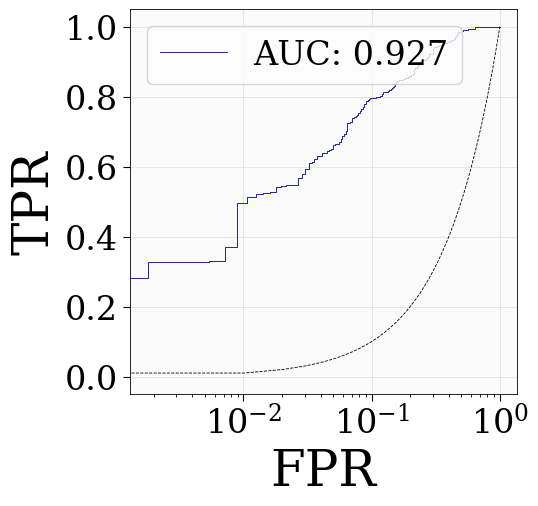

In [9]:
# Now for each individual in the test data, let's find the probability that 
# they belong to the max treatment effect group

zeta_probs_test_CMHE = model.predict_latent_phi(x_te)
zeta_test =  np.argmax(zeta_probs_test_CMHE, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the test data: \
{np.unique(zeta_test, return_counts=True)[1]}')

# Now let us evaluate our performance
plot_phenotypes_roc(outcomes_te, zeta_probs_test_CMHE[:, max_treat_idx_CMHE])

<a id="clustering"></a>
### 3.3 Comparison with the Clustering phenotyper

We compare the ability of CMHE against dimensionality reduction followed by clustering for counterfactual phenotyping. Specifically, we first perform dimensionality reduction of the input confounders, $\mathbf{x}$, followed by clustering. Due to a small number of confounders in the synthetic data, in the following experiment, we directly perform clustering using a Gaussian Mixture Model (GMM) with 2 components and diagonal covariance matrices.

In [10]:
from phenotyping import ClusteringPhenotyper
from sklearn.metrics import auc

clustering_method = 'gmm'
dim_red_method = None # We would not perform dimensionality reduction for the synthetic dataset
n_components = None 
n_clusters = 2 # Number of underlying treatment effect phenotypes

# Running the phenotyper
phenotyper = ClusteringPhenotyper(clustering_method=clustering_method, 
                                  dim_red_method=dim_red_method, 
                                  n_components=n_components, 
                                  n_clusters=n_clusters,
                                  random_seed=36) 

In [11]:
zeta_probs_train = phenotyper.fit(features_tr.values).predict_proba(features_tr.values)
zeta_train = phenotyper.fit_predict(features_tr.values)
print(f'Distribution of individuals in each treatement phenotype in the training data: \
{np.unique(zeta_train, return_counts=True)[1]}')

max_treat_idx_CP = find_max_treatment_effect_phenotype(
    g=2, zeta_probs=zeta_probs_train, factual_outcomes=(outcomes_tr, interventions_tr))
print(f'\nGroup {max_treat_idx_CP} has the maximum restricted mean survival time on the training data!')

No Dimensionaity reduction specified...
 Proceeding to learn clusters with the raw features...
Fitting the following Clustering Model:
 GaussianMixture(covariance_type='diag', n_components=3, random_state=36)
No Dimensionaity reduction specified...
 Proceeding to learn clusters with the raw features...
Fitting the following Clustering Model:
 GaussianMixture(covariance_type='diag', n_components=3, random_state=36)
Distribution of individuals in each treatement phenotype in the training data: [1285 1425 1189]

Group 0 has the maximum restricted mean survival time on the training data!


### Evaluate Clustering Phenotyper on Test Data

Distribution of individuals in each treatement phenotype in the test data: [356 370 375]


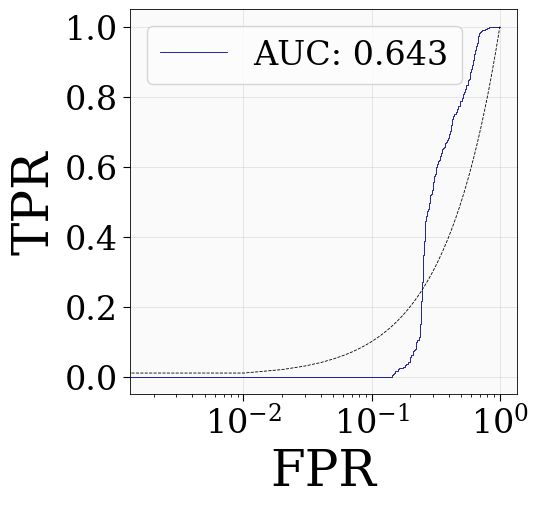

In [12]:
# Now for each individual in the test data, let's find the probability that 
# they belong to the max treatment effect group

# Use the phenotyper trained on training data to phenotype on testing data
zeta_probs_test_CP = phenotyper.predict_proba(x_te)
zeta_test_CP =  np.argmax(zeta_probs_test_CP, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the test data: \
{np.unique(zeta_test_CP, return_counts=True)[1]}')

# Now let us evaluate our performance
plot_phenotypes_roc(outcomes_te, zeta_probs_test_CP[:, max_treat_idx_CP])

<a id="regression"></a>
## 4. CMHE for Factual Regression

For completeness, we further evaluate the performance of CMHE in estimating factual risk over multiple time horizons using the standard survival analysis metrics, including: 

1. $\textbf{Brier Score} \ (\textrm{BS})$: Defined as the Mean Squared Error (MSE) around the probabilistic prediction at a certain time horizon.
\begin{align}
\text{BS}(t) = \mathop{\mathbf{E}}_{x\sim\mathcal{D}}\big[ ||\mathbf{1}\{ T > t \} - \widehat{\mathbf{P}}(T>t|X)\big)||_{_\textbf{2}}^\textbf{2}  \big]
\end{align}
2. $ \textbf{Time Dependent Concordance Index} \ (C^{\text{td}}$): A rank order statistic that computes model performance in ranking patients based on their estimated risk at a specfic time horizon.
\begin{align}
C^{td }(t) = \mathbf{P}\big( \hat{F}(t| \mathbf{x}_i) > \hat{F}(t| \mathbf{x}_j)  | \delta_i=1, T_i<T_j, T_i \leq t \big) 
\end{align}

We compute the censoring adjusted estimates of the Time Dependent Concordance Index (Antolini et al., 2005; Gerds et al., 2013) and the Integrated Brier Score (i.e. Brier Score integrated over 1, 3 and 5 years. $\text{IBS} = \mathop{\sum}_t  \frac{t}{t_\text{max}}  \cdot \text{BS}(t)$) (Gerds and Schumacher, 2006; Graf et al., 1999) to assess both discriminative performance and model calibration at multiple time horizons.

*We find that CMHE had similar or better discriminative performance than a simple Cox Model with MLP hazard functions. CMHE was also better calibrated as evidenced by overall lower Integrated Brier Score, suggesting utility for factual risk estimation.*

<a id="regcmhe"></a>

### 4.1 Factual Regression Performance of  CMHE

In [13]:
horizons = [1, 3, 5]

# Now let us predict survival using CMHE
predictions_test_CMHE = model.predict_survival(x_te, a_te, t=horizons)

CI1, CI3, CI5, IBS = factual_evaluate((x_tr, t_tr, e_tr, a_tr), (x_te, t_te, e_te, a_te), 
                                      horizons, predictions_test_CMHE)
print(f'Concordance Index (1 Year): {np.around(CI1, 4)} (3 Year) {np.around(CI3, 4)}: (5 Year): {np.around(CI5, 4)}')
print(f'Integrated Brier Score: {np.around(IBS, 4)}')

Concordance Index (1 Year): 0.7023 (3 Year) 0.7048: (5 Year): 0.7032
Integrated Brier Score: 0.1525


<a id="deepcph"></a>
### 4.2 Comparison with Deep Cox-Proportional Hazards Model

In [14]:
from auton_survival.estimators import SurvivalModel

# Now let us train a Deep Cox-proportional Hazard model with two linear layers and tanh activations
dcph_model = SurvivalModel('dcph', random_seed=0, bs=100, learning_rate=1e-3, layers=[50, 50])

interventions_tr.name, interventions_te.name = 'treat', 'treat'
features_tr_dcph = pd.concat([features_tr, interventions_tr.astype('float64')], axis=1)
features_te_dcph = pd.concat([features_te, interventions_te.astype('float64')], axis=1)
outcomes_tr_dcph = pd.DataFrame(outcomes_tr, columns=['event', 'time']).astype('float64')

# Train the DCPH model
dcph_model = dcph_model.fit(features_tr_dcph, outcomes_tr_dcph)

100%|██████████| 50/50 [00:01<00:00, 47.36it/s]


### Evaluate DCPH on Test Data

In [15]:
# Find suvival scores in the test data
predictions_test_DCPH = dcph_model.predict_survival(features_te_dcph, horizons)

CI1, CI3, CI5, IBS = factual_evaluate((x_tr, t_tr, e_tr, a_tr), (x_te, t_te, e_te, a_te), 
                                      horizons, predictions_test_DCPH)
print(f'Concordance Index (1 Year): {np.around(CI1, 4)} (3 Year) {np.around(CI3, 4)}: (5 Year): {np.around(CI5, 4)}')
print(f'Integrated Brier Score: {np.around(IBS, 4)}')

Concordance Index (1 Year): 0.6915 (3 Year) 0.6932: (5 Year): 0.6988
Integrated Brier Score: 0.1532


In [16]:
features

,X1,X2,X3,X4,X5,X6,X7,X8
0,0.148745,1.892484,0.195254,0.860757,0.696523,0.483697,0.339551,0.374794
1,1.139439,-0.943330,0.411054,0.179533,0.428686,0.683057,0.600948,0.070483
2,-0.961237,0.782706,-0.305381,0.583576,0.157478,0.070556,0.034590,0.776005
3,0.466508,0.694348,-0.249651,1.567092,0.850959,0.416178,0.968841,0.863598
4,-0.249002,-0.552091,1.854651,-0.466234,0.860385,0.367184,0.954347,0.748930
...,...,...,...,...,...,...,...,...
4995,0.377835,2.432757,0.779933,-1.221572,0.505301,0.928557,0.328742,0.207052
4996,-1.018245,-1.553523,-1.543853,-0.951537,0.481382,0.437604,0.743311,0.292312
4997,-1.585228,-0.796665,0.942009,0.201787,0.155891,0.634361,0.544946,0.011244
4998,0.254141,1.583503,-0.411395,1.033718,0.452547,0.369376,0.054975,0.567739
